# Calculating the Customer Segmentation for Banking Industry

# Imports

In [1]:
import os
import sys
import seaborn as sns
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib
import plydata.cat_tools as cat
import plotnine as pn
pn.options.dpi = 300

from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import GridSearchCV



import warnings
warnings.filterwarnings('ignore')



# Constants

In [2]:
ACCOUNT_DATA = pd.read_csv('TASK_DATASCIENCE.CSV')
TRANSACION_DATA = pd.read_csv('TASK_DATASCIENCE_TRAN.CSV')
TRANSACION_DATA['TRAN_DATE'] = TRANSACION_DATA['TRAN_DATE'].apply(pd.Period)
LAST_TR = TRANSACION_DATA['TRAN_DATE'].max()
FIRST_TR = TRANSACION_DATA['TRAN_DATE'].min()
N_DAYS = ((TRANSACION_DATA['TRAN_DATE'].max()-TRANSACION_DATA['TRAN_DATE'].min())/ np.timedelta64(1, 'D'))-30




# Feature Engineering

In [3]:
max_date = TRANSACION_DATA['TRAN_DATE'].max()
dpoint = max_date - pd.to_timedelta(N_DAYS, unit= 'd')

In [4]:
#first and last transaction of the year
t_in = TRANSACION_DATA[TRANSACION_DATA['TRAN_DATE']<= dpoint]
t_out = TRANSACION_DATA[TRANSACION_DATA['TRAN_DATE'] > dpoint]
t_in

,ACC_NO,TRAN_AMT,TRAN_CAT,TRAN_DATE
0,18583,1.500000e+08,C,1399-08-27
1,18583,1.500000e+08,C,1399-08-28
2,18583,3.000000e+08,D,1399-08-29
3,18583,9.344262e+06,C,1399-08-30
4,18583,1.518443e+08,C,1399-08-30
...,...,...,...,...
33848,16814187,5.400000e+09,C,1399-08-29
33849,16814187,2.100000e+09,C,1399-08-29
33850,16814187,1.350000e+09,C,1399-08-29
33851,16814187,4.500000e+08,C,1399-08-29


In [5]:
t_out

,ACC_NO,TRAN_AMT,TRAN_CAT,TRAN_DATE
8,18583,1.106557e+07,C,1399-09-30
9,18583,8.852458e+06,C,1399-09-30
10,18583,1.518443e+08,C,1399-09-30
11,18583,9.344262e+06,C,1399-09-30
12,18583,1.475275e+07,C,1399-09-30
...,...,...,...,...
34056,16841811,3.000000e+04,D,1399-10-29
34057,16842215,7.500000e+05,C,1399-10-29
34058,16842215,3.000000e+04,D,1399-10-29
34059,16842215,3.000000e+04,D,1399-10-29


In [6]:
# targeting the Valuable accounts by their Transaction for the past 60 days

targeted_acc = t_out.groupby(['ACC_NO', 'TRAN_CAT']).agg({'TRAN_AMT': ['sum']})
targeted_acc.columns = ['Total 60']
targeted_acc = targeted_acc.reset_index()
targeted_acc = targeted_acc.pivot(index=['ACC_NO'], columns=['TRAN_CAT'], values=['Total 60']).fillna(0)
targeted_acc = pd.DataFrame(targeted_acc.reset_index())
new_ax = {('ACC_NO', ' '): 'ACC_NO',
             ('Total 60', 'C'): 'Total 60 C', ('Total 60', 'D'): 'Total 60 D'}

targeted_acc.columns = [' '.join(col).strip() for col in targeted_acc.columns.values]
targeted_acc.rename(columns=new_ax)
targeted_acc = targeted_acc.assign(total_flag_C = 1, total_flag_D = 1)
targeted_acc

,ACC_NO,Total 60 C,Total 60 D,total_flag_C,total_flag_D
0,18583,3.930029e+08,0.000000e+00,1,1
1,14155153,1.500000e+08,0.000000e+00,1,1
2,14156227,3.375000e+10,3.412519e+10,1,1
3,14186083,1.302450e+04,0.000000e+00,1,1
4,14186179,8.974845e+05,0.000000e+00,1,1
...,...,...,...,...,...
375,16840317,3.750000e+10,3.750000e+10,1,1
376,16841535,3.755533e+10,5.532787e+07,1,1
377,16841811,1.500000e+06,2.550000e+05,1,1
378,16842215,7.500000e+05,6.000000e+04,1,1


In [7]:
# Building the the Feautures needed: (RFM model)

features = t_in.groupby(['ACC_NO', 'TRAN_CAT']).agg({
                                            'TRAN_DATE': lambda y: (t_in['TRAN_DATE'].max() - y.min()),
                                            'TRAN_CAT': lambda y: len(y),
                                            'TRAN_AMT': ['sum', 'mean']
                                            })

features.columns = ['Recency', 'Frequency', 'Monetary', 'Mean']
features['Recency'] = (features['Recency'] / np.timedelta64(1, 'D')).astype(int)
features = pd.DataFrame(features.reset_index())
# amt
features = features.pivot(index=['ACC_NO'], columns=['TRAN_CAT'], values=['Monetary','Recency','Frequency', 'Mean']).fillna(0)
features = pd.DataFrame(features.reset_index())

new_names = {('ACC_NO', ' '): 'ACC_NO',
             ('Mean', 'C'): 'Mean C', ('Mean', 'D'): 'Mean D',
             ('Monetary', 'C'): 'Monetary C', ('Monetary', 'D'): 'Monetary D',
             ('Recency', 'C'): 'Recency C', ('Recency', 'D'): 'Recency D',
             ('Frequency', 'C'): 'Frequency C', ('Frequency', 'D'): 'Frequency D'}
features.columns = [' '.join(col).strip() for col in features.columns.values]

features = features.rename(columns=new_names)
features

,ACC_NO,Monetary C,Monetary D,Recency C,Recency D,Frequency C,Frequency D,Mean C,Mean D
0,18583,4.945834e+08,3.000000e+08,3.0,1.0,7.0,1.0,7.065476e+07,3.000000e+08
1,14156227,2.421161e+09,2.033501e+09,29.0,27.0,8.0,16.0,3.026451e+08,1.270938e+08
2,14186083,6.448500e+03,0.000000e+00,0.0,0.0,1.0,0.0,6.448500e+03,0.000000e+00
3,14186179,4.443615e+05,0.000000e+00,0.0,0.0,1.0,0.0,4.443615e+05,0.000000e+00
4,14202231,1.901238e+06,0.000000e+00,0.0,0.0,1.0,0.0,1.901238e+06,0.000000e+00
...,...,...,...,...,...,...,...,...,...
354,16809909,9.000000e+08,0.000000e+00,11.0,0.0,2.0,0.0,4.500000e+08,0.000000e+00
355,16810997,5.850000e+09,5.850000e+09,8.0,1.0,1.0,1.0,5.850000e+09,5.850000e+09
356,16812403,8.493525e+07,1.852455e+05,5.0,0.0,2.0,1.0,4.246762e+07,1.852455e+05
357,16812441,3.397410e+08,7.409835e+05,5.0,0.0,2.0,1.0,1.698705e+08,7.409835e+05


In [8]:
# Merging the Tables

c_features = pd.merge(features, targeted_acc, how='left', left_on='ACC_NO', right_on='ACC_NO')
c_features = c_features.fillna(0)

c_features.loc[c_features['Total 60 D'] == 0, 'total_flag_D'] = 0
c_features.loc[c_features['Total 60 C'] == 0, 'total_flag_C'] = 0
c_features

,ACC_NO,Monetary C,Monetary D,Recency C,Recency D,Frequency C,Frequency D,Mean C,Mean D,Total 60 C,Total 60 D,total_flag_C,total_flag_D
0,18583,4.945834e+08,3.000000e+08,3.0,1.0,7.0,1.0,7.065476e+07,3.000000e+08,3.930029e+08,0.000000e+00,1.0,0.0
1,14156227,2.421161e+09,2.033501e+09,29.0,27.0,8.0,16.0,3.026451e+08,1.270938e+08,3.375000e+10,3.412519e+10,1.0,1.0
2,14186083,6.448500e+03,0.000000e+00,0.0,0.0,1.0,0.0,6.448500e+03,0.000000e+00,1.302450e+04,0.000000e+00,1.0,0.0
3,14186179,4.443615e+05,0.000000e+00,0.0,0.0,1.0,0.0,4.443615e+05,0.000000e+00,8.974845e+05,0.000000e+00,1.0,0.0
4,14202231,1.901238e+06,0.000000e+00,0.0,0.0,1.0,0.0,1.901238e+06,0.000000e+00,1.717134e+10,1.650000e+10,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,16809909,9.000000e+08,0.000000e+00,11.0,0.0,2.0,0.0,4.500000e+08,0.000000e+00,3.000000e+08,0.000000e+00,1.0,0.0
355,16810997,5.850000e+09,5.850000e+09,8.0,1.0,1.0,1.0,5.850000e+09,5.850000e+09,0.000000e+00,0.000000e+00,0.0,0.0
356,16812403,8.493525e+07,1.852455e+05,5.0,0.0,2.0,1.0,4.246762e+07,1.852455e+05,2.222952e+06,2.222952e+06,1.0,1.0
357,16812441,3.397410e+08,7.409835e+05,5.0,0.0,2.0,1.0,1.698705e+08,7.409835e+05,8.891802e+06,8.891802e+06,1.0,1.0


In [9]:
# Deleting the inactive Accounts 

active_acc = ACCOUNT_DATA.drop(
    index=ACCOUNT_DATA[ACCOUNT_DATA['ACCT_STATUS']=='C'].index
         )

active_acc = pd.DataFrame(active_acc.reset_index())

active_acc['SYM_RUN_DATE'] = pd.to_datetime(active_acc['SYM_RUN_DATE'])
active_acc

,index,SYM_RUN_DATE,ACC_NO,OPEN_DATE,ACCT_STATUS,ACC_TYPE,BAL_RLS
0,0,2020-12-28,16194791,1395/10/06,A,30,3.920629e+09
1,1,2020-11-19,16194791,1395/10/06,A,30,3.920629e+09
2,2,2020-10-24,16194791,1395/10/06,A,30,3.920629e+09
3,3,2020-11-14,16194791,1395/10/06,A,30,3.920629e+09
4,4,2020-11-29,16194791,1395/10/06,A,30,3.920629e+09
...,...,...,...,...,...,...,...
31915,82057,2020-04-11,14568173,1387/10/10,A,2,1.018796e+09
31916,82058,2020-12-12,14568173,1387/10/10,A,2,1.139821e+09
31917,82059,2020-12-23,14568173,1387/10/10,A,2,1.261639e+09
31918,82060,2020-12-20,14568173,1387/10/10,A,2,1.261639e+09


In [10]:
# Sorting and Indexing the table

acc = active_acc.groupby(['ACC_NO','ACC_TYPE'])['SYM_RUN_DATE','BAL_RLS'].max()
acc = pd.DataFrame(acc)

acc = acc.reset_index()
acc

,ACC_NO,ACC_TYPE,SYM_RUN_DATE,BAL_RLS
0,18583,2,2021-12-01,2.642798e+09
1,14155153,1,2021-12-01,1.575000e+08
2,14156227,1,2021-12-01,2.206610e+10
3,14186083,5,2021-12-01,1.002888e+06
4,14186179,2,2021-12-01,6.910707e+07
...,...,...,...,...
462,16840317,111,2021-01-14,3.750000e+10
463,16841535,111,2021-01-19,3.750000e+10
464,16841811,3,2021-01-19,1.245000e+06
465,16842215,19,2021-01-19,6.900000e+05


In [11]:
# finalizing the DataFrame

df = pd.merge(c_features, acc, how='left', left_on='ACC_NO', right_on='ACC_NO')
df.to_csv('my_data.csv')
df

,ACC_NO,Monetary C,Monetary D,Recency C,Recency D,Frequency C,Frequency D,Mean C,Mean D,Total 60 C,Total 60 D,total_flag_C,total_flag_D,ACC_TYPE,SYM_RUN_DATE,BAL_RLS
0,18583,4.945834e+08,3.000000e+08,3.0,1.0,7.0,1.0,7.065476e+07,3.000000e+08,3.930029e+08,0.000000e+00,1.0,0.0,2.0,2021-12-01,2.642798e+09
1,14156227,2.421161e+09,2.033501e+09,29.0,27.0,8.0,16.0,3.026451e+08,1.270938e+08,3.375000e+10,3.412519e+10,1.0,1.0,1.0,2021-12-01,2.206610e+10
2,14186083,6.448500e+03,0.000000e+00,0.0,0.0,1.0,0.0,6.448500e+03,0.000000e+00,1.302450e+04,0.000000e+00,1.0,0.0,5.0,2021-12-01,1.002888e+06
3,14186179,4.443615e+05,0.000000e+00,0.0,0.0,1.0,0.0,4.443615e+05,0.000000e+00,8.974845e+05,0.000000e+00,1.0,0.0,2.0,2021-12-01,6.910707e+07
4,14202231,1.901238e+06,0.000000e+00,0.0,0.0,1.0,0.0,1.901238e+06,0.000000e+00,1.717134e+10,1.650000e+10,1.0,1.0,5.0,2021-12-01,9.293754e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,16809909,9.000000e+08,0.000000e+00,11.0,0.0,2.0,0.0,4.500000e+08,0.000000e+00,3.000000e+08,0.000000e+00,1.0,0.0,92.0,2021-12-01,1.200000e+09
365,16810997,5.850000e+09,5.850000e+09,8.0,1.0,1.0,1.0,5.850000e+09,5.850000e+09,0.000000e+00,0.000000e+00,0.0,0.0,92.0,2021-12-01,5.850000e+09
366,16812403,8.493525e+07,1.852455e+05,5.0,0.0,2.0,1.0,4.246762e+07,1.852455e+05,2.222952e+06,2.222952e+06,1.0,1.0,4.0,2021-12-01,8.475000e+07
367,16812441,3.397410e+08,7.409835e+05,5.0,0.0,2.0,1.0,1.698705e+08,7.409835e+05,8.891802e+06,8.891802e+06,1.0,1.0,4.0,2021-12-01,3.390000e+08


# ML

## Mashine learning model to predict and scoring the Account by RFM model

## Constants

In [12]:
XC = df[['Monetary C', 'Recency C', 'Frequency C', 'Mean C', 'BAL_RLS']]
XD = df[['Monetary D', 'Recency D', 'Frequency D', 'Mean D', 'BAL_RLS']]
YC = df['Total 60 C']
YD = df['Total 60 D']
YC_PROB = df['total_flag_C']
YD_PROB = df['total_flag_D']

## Model

In [ ]:
xgb_spec_c = XGBRegressor(objective='reg:squarederror', random_state=123)
xgb_reg_model_c = GridSearchCV(estimator = xgb_spec_c,
                            param_grid=dict(
                            learning_state=(0.01, 0.1, 0.3, 0.5)),
                            scoring='neg_mean_absolute_error',
                            refit=True,
                            cv= 5
                            )

xgb_reg_model_c.fit(XC, YC)
predic_reg_c = xgb_reg_model_c.predict(XC)

In [14]:
xgb_reg_model_c.best_score_

-99914951101.12595

In [ ]:
xgb_spec_d = XGBRegressor(objective='reg:squarederror', random_state=123)
xgb_reg_model_d = GridSearchCV(estimator = xgb_spec_d,
                            param_grid=dict(
                            learning_state=(0.01, 0.1, 0.3, 0.5)),
                            scoring='neg_mean_absolute_error',
                            refit=True,
                            cv= 5
                            )

xgb_reg_model_d.fit(XD, YD)
predic_reg_d = xgb_reg_model_d.predict(XD)

In [16]:
xgb_reg_model_d.best_score_

-129131389590.97697

In [ ]:

xgb_clf_spec_c = XGBClassifier(objective='binary:logistic', random_state=123)
xgb_clf_model_c = GridSearchCV(estimator = xgb_clf_spec_c,
                            param_grid=dict(
                            learning_state=(0.01, 0.1, 0.3, 0.5)),
                            scoring='roc_auc',
                            refit=True,
                            cv= 5
                            )
xgb_clf_model_c.fit(XC, YC_PROB)



In [18]:
xgb_clf_model_c.best_score_

0.9500350140056023

In [19]:
prediction_clf_c = xgb_clf_model_c.predict_proba(XC)


In [ ]:
xgb_clf_spec_d = XGBClassifier(objective='binary:logistic', random_state=123)
xgb_clf_model_d = GridSearchCV(estimator = xgb_clf_spec_d,
                            param_grid=dict(
                            learning_state=(0.01, 0.1, 0.3, 0.5)),
                            scoring='roc_auc',
                            refit=True,
                            cv= 5
                            )
xgb_clf_model_d.fit(XD, YD_PROB)



In [21]:
xgb_clf_model_d.best_score_

0.9276670870113491

In [22]:
prediction_reg_c = xgb_clf_model_c.predict(XC)
prediction_reg_d = xgb_clf_model_d.predict(XD)

prediction_clf_c = xgb_clf_model_c.predict_proba(XC)
prediction_clf_d = xgb_clf_model_d.predict_proba(XD)


### Impact of each element of RFM Model on Account values

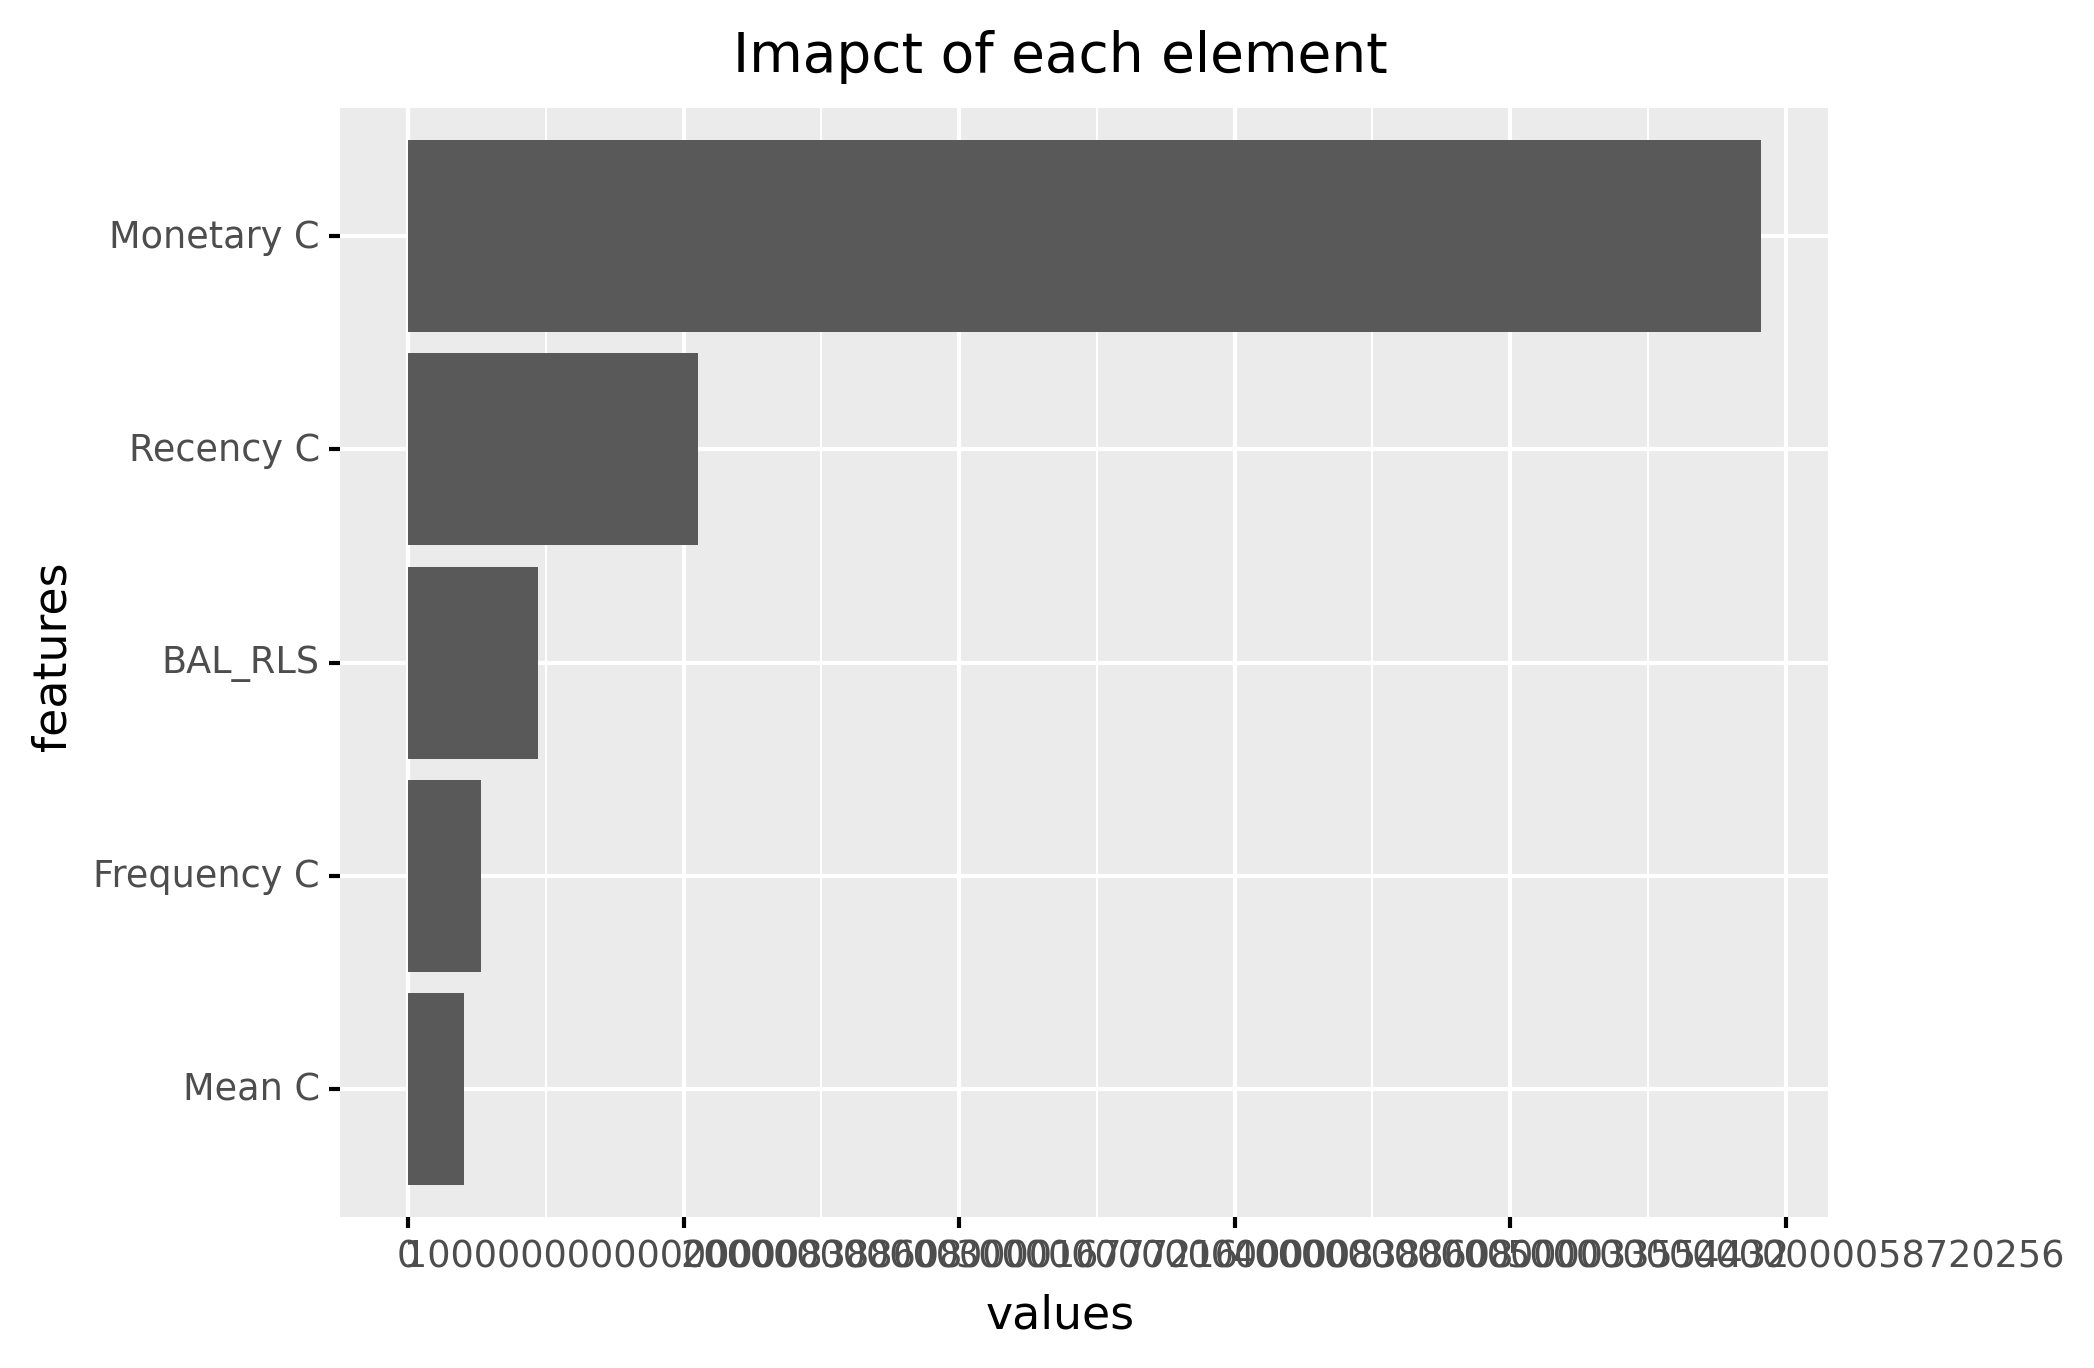

<ggplot: (119860646250)>

In [23]:
# this Calculate based on Amount of money each account had bringed in.

imp_C_dict = xgb_reg_model_c.best_estimator_.get_booster().get_score(importance_type='gain')
imp_C_df = pd.DataFrame(data = {'features': list(imp_C_dict.keys()),
                                     'values': list(imp_C_dict.values())
                                    })
imp_C_df = imp_C_df.assign(features = lambda x: cat.cat_reorder(x['features'], x['values'])) 
pn.ggplot(
        pn.aes('features', 'values'), 
        data = imp_C_df) + pn.geom_col() + pn.coord_flip() + pn.ggtitle('Imapct of each element')

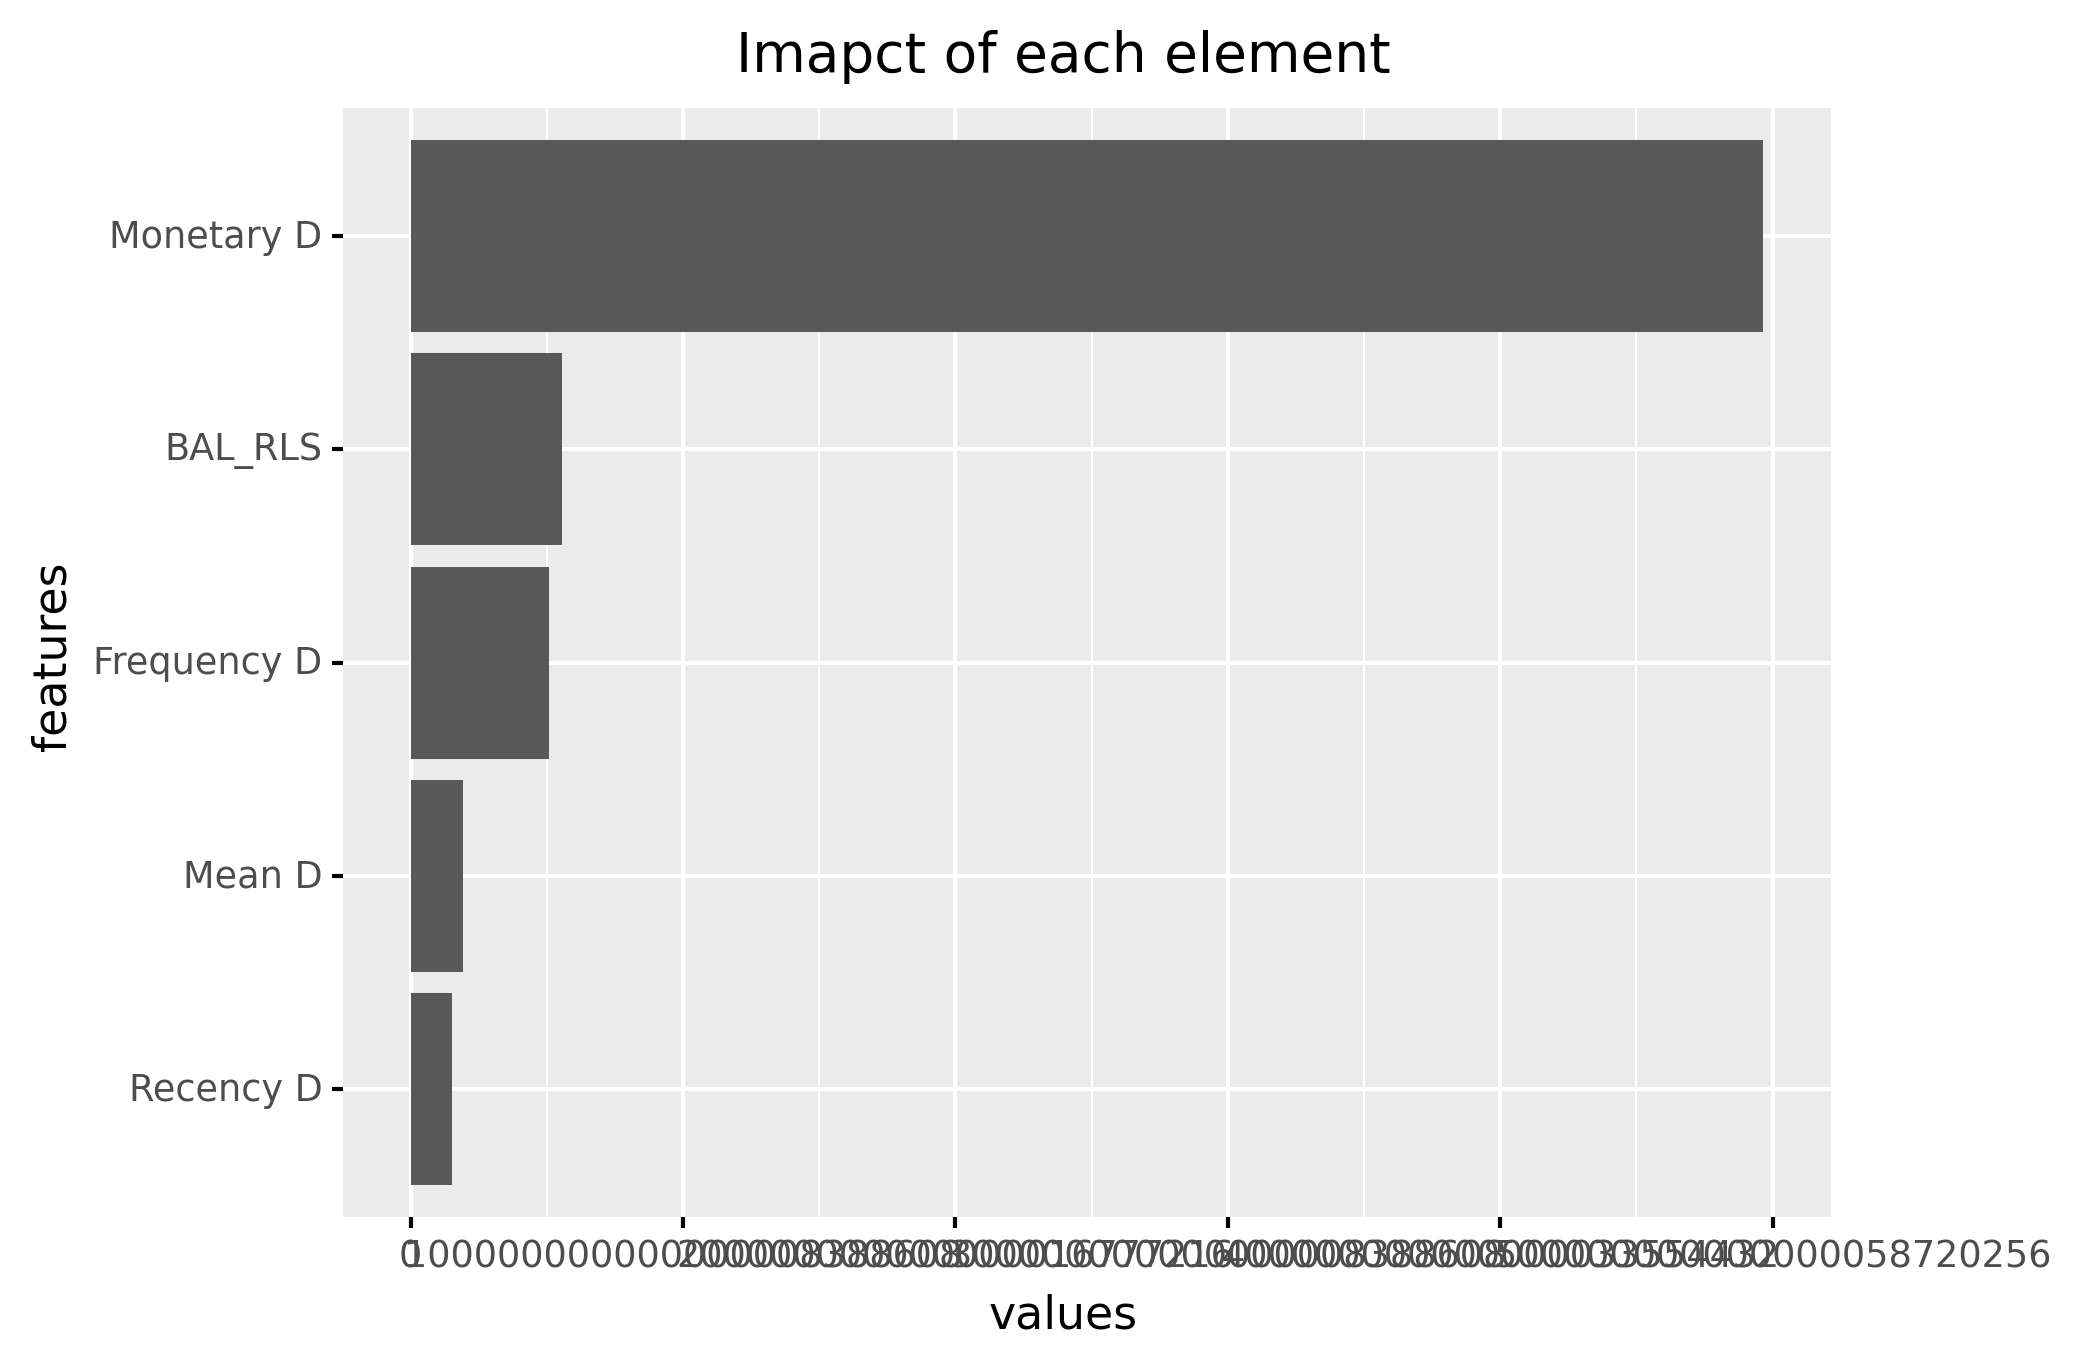

<ggplot: (119860649039)>

In [24]:
# this Calculate based on Amount of money each account had withdrawn.

imp_D_dict = xgb_reg_model_d.best_estimator_.get_booster().get_score(importance_type='gain')
imp_D_df = pd.DataFrame(data = {'features': list(imp_D_dict.keys()),
                                     'values': list(imp_D_dict.values())
                                    })
imp_D_df = imp_D_df.assign(features = lambda x: cat.cat_reorder(x['features'], x['values'])) 
pn.ggplot(
        pn.aes('features', 'values'), 
        data = imp_D_df) + pn.geom_col() + pn.coord_flip() + pn.ggtitle('Imapct of each element')

# Predictions

In [25]:
predictions_c_reg = pd.DataFrame(prediction_reg_c).set_axis(['prediction_c'], axis=1)
predictions_d_reg = pd.DataFrame(prediction_reg_d).set_axis(['prediction_d'], axis=1)
predictions_c_clf = pd.DataFrame(prediction_clf_c)[[1]].set_axis(['pred_c_prob'], axis=1)
predictions_d_clf = pd.DataFrame(prediction_clf_d)[[1]].set_axis(['pred_d_prob'], axis=1)


In [26]:
predictions_df = pd.concat(
    [df.reset_index(), predictions_c_reg, predictions_d_reg, predictions_c_clf, predictions_d_clf], axis=1)
predictions_df

,index,ACC_NO,Monetary C,Monetary D,Recency C,Recency D,Frequency C,Frequency D,Mean C,Mean D,...,Total 60 D,total_flag_C,total_flag_D,ACC_TYPE,SYM_RUN_DATE,BAL_RLS,prediction_c,prediction_d,pred_c_prob,pred_d_prob
0,0,18583,4.945834e+08,3.000000e+08,3.0,1.0,7.0,1.0,7.065476e+07,3.000000e+08,...,0.000000e+00,1.0,0.0,2.0,2021-12-01,2.642798e+09,1.0,0.0,0.996844,0.234120
1,1,14156227,2.421161e+09,2.033501e+09,29.0,27.0,8.0,16.0,3.026451e+08,1.270938e+08,...,3.412519e+10,1.0,1.0,1.0,2021-12-01,2.206610e+10,1.0,1.0,0.998546,0.999610
2,2,14186083,6.448500e+03,0.000000e+00,0.0,0.0,1.0,0.0,6.448500e+03,0.000000e+00,...,0.000000e+00,1.0,0.0,5.0,2021-12-01,1.002888e+06,1.0,0.0,0.711300,0.167080
3,3,14186179,4.443615e+05,0.000000e+00,0.0,0.0,1.0,0.0,4.443615e+05,0.000000e+00,...,0.000000e+00,1.0,0.0,2.0,2021-12-01,6.910707e+07,1.0,0.0,0.999644,0.042770
4,4,14202231,1.901238e+06,0.000000e+00,0.0,0.0,1.0,0.0,1.901238e+06,0.000000e+00,...,1.650000e+10,1.0,1.0,5.0,2021-12-01,9.293754e+09,1.0,1.0,0.989330,0.991432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,364,16809909,9.000000e+08,0.000000e+00,11.0,0.0,2.0,0.0,4.500000e+08,0.000000e+00,...,0.000000e+00,1.0,0.0,92.0,2021-12-01,1.200000e+09,1.0,0.0,0.956667,0.053076
365,365,16810997,5.850000e+09,5.850000e+09,8.0,1.0,1.0,1.0,5.850000e+09,5.850000e+09,...,0.000000e+00,0.0,0.0,92.0,2021-12-01,5.850000e+09,0.0,0.0,0.096020,0.053212
366,366,16812403,8.493525e+07,1.852455e+05,5.0,0.0,2.0,1.0,4.246762e+07,1.852455e+05,...,2.222952e+06,1.0,1.0,4.0,2021-12-01,8.475000e+07,1.0,1.0,0.997182,0.998489
367,367,16812441,3.397410e+08,7.409835e+05,5.0,0.0,2.0,1.0,1.698705e+08,7.409835e+05,...,8.891802e+06,1.0,1.0,4.0,2021-12-01,3.390000e+08,1.0,1.0,0.996994,0.997174


# Exports

In [27]:
predictions_df.to_pickle('predictions.pkl')
imp_C_df.to_pickle('imp_C_df.pkl')
imp_D_df.to_pickle('imp_D_df.pkl')

joblib.dump(xgb_reg_model_c, 'xgb_reg_model_c.pkl')
joblib.dump(xgb_reg_model_d, 'xgb_reg_model_d.pkl')
joblib.dump(xgb_clf_model_c, 'xgb_clf_model_c.pkl')
joblib.dump(xgb_clf_model_d, 'xgb_clf_model_d.pkl')


['xgb_clf_model_d.pkl']

In [28]:
predictions_df.sort_values('pred_c_prob', ascending=False)
predictions_df

,index,ACC_NO,Monetary C,Monetary D,Recency C,Recency D,Frequency C,Frequency D,Mean C,Mean D,...,Total 60 D,total_flag_C,total_flag_D,ACC_TYPE,SYM_RUN_DATE,BAL_RLS,prediction_c,prediction_d,pred_c_prob,pred_d_prob
0,0,18583,4.945834e+08,3.000000e+08,3.0,1.0,7.0,1.0,7.065476e+07,3.000000e+08,...,0.000000e+00,1.0,0.0,2.0,2021-12-01,2.642798e+09,1.0,0.0,0.996844,0.234120
1,1,14156227,2.421161e+09,2.033501e+09,29.0,27.0,8.0,16.0,3.026451e+08,1.270938e+08,...,3.412519e+10,1.0,1.0,1.0,2021-12-01,2.206610e+10,1.0,1.0,0.998546,0.999610
2,2,14186083,6.448500e+03,0.000000e+00,0.0,0.0,1.0,0.0,6.448500e+03,0.000000e+00,...,0.000000e+00,1.0,0.0,5.0,2021-12-01,1.002888e+06,1.0,0.0,0.711300,0.167080
3,3,14186179,4.443615e+05,0.000000e+00,0.0,0.0,1.0,0.0,4.443615e+05,0.000000e+00,...,0.000000e+00,1.0,0.0,2.0,2021-12-01,6.910707e+07,1.0,0.0,0.999644,0.042770
4,4,14202231,1.901238e+06,0.000000e+00,0.0,0.0,1.0,0.0,1.901238e+06,0.000000e+00,...,1.650000e+10,1.0,1.0,5.0,2021-12-01,9.293754e+09,1.0,1.0,0.989330,0.991432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,364,16809909,9.000000e+08,0.000000e+00,11.0,0.0,2.0,0.0,4.500000e+08,0.000000e+00,...,0.000000e+00,1.0,0.0,92.0,2021-12-01,1.200000e+09,1.0,0.0,0.956667,0.053076
365,365,16810997,5.850000e+09,5.850000e+09,8.0,1.0,1.0,1.0,5.850000e+09,5.850000e+09,...,0.000000e+00,0.0,0.0,92.0,2021-12-01,5.850000e+09,0.0,0.0,0.096020,0.053212
366,366,16812403,8.493525e+07,1.852455e+05,5.0,0.0,2.0,1.0,4.246762e+07,1.852455e+05,...,2.222952e+06,1.0,1.0,4.0,2021-12-01,8.475000e+07,1.0,1.0,0.997182,0.998489
367,367,16812441,3.397410e+08,7.409835e+05,5.0,0.0,2.0,1.0,1.698705e+08,7.409835e+05,...,8.891802e+06,1.0,1.0,4.0,2021-12-01,3.390000e+08,1.0,1.0,0.996994,0.997174


In [29]:
un_col = ['Monetary C', 'Monetary D', 'Recency C', 'Recency D', 
          'Frequency C', 'Frequency D', 'Mean C', 'Mean D', 'total_flag_C',
         'total_flag_C', 'total_flag_D', 'ACC_TYPE', 'SYM_RUN_DATE', 'index', 'BAL_RLS',
         'prediction_c', 'prediction_d']

seg_df = predictions_df.drop(un_col, axis=1)
seg_df['Total 60 diff'] = seg_df['Total 60 C'] - seg_df['Total 60 D']
col_seg_names = ['Total 60 C', 'Total 60 D', 'pred_c_prob', 'pred_d_prob', 'Total 60 diff']
seg_df

,ACC_NO,Total 60 C,Total 60 D,pred_c_prob,pred_d_prob,Total 60 diff
0,18583,3.930029e+08,0.000000e+00,0.996844,0.234120,3.930029e+08
1,14156227,3.375000e+10,3.412519e+10,0.998546,0.999610,-3.751938e+08
2,14186083,1.302450e+04,0.000000e+00,0.711300,0.167080,1.302450e+04
3,14186179,8.974845e+05,0.000000e+00,0.999644,0.042770,8.974845e+05
4,14202231,1.717134e+10,1.650000e+10,0.989330,0.991432,6.713400e+08
...,...,...,...,...,...,...
364,16809909,3.000000e+08,0.000000e+00,0.956667,0.053076,3.000000e+08
365,16810997,0.000000e+00,0.000000e+00,0.096020,0.053212,0.000000e+00
366,16812403,2.222952e+06,2.222952e+06,0.997182,0.998489,0.000000e+00
367,16812441,8.891802e+06,8.891802e+06,0.996994,0.997174,0.000000e+00


# Segmentations Based on features

In [30]:

seg_df["Customer segment C"]=np.where(seg_df["Total 60 C"] > seg_df["Total 60 C"].quantile(0.75) ,"High Value Customer",
                                      (np.where(seg_df["Total 60 C"] < seg_df["Total 60 C"].quantile(0.25) , "Low value Customer" ,
                                                "Medium Value Customer")))
seg_df["Customer segment D"]=np.where(seg_df["Total 60 C"] < seg_df["Total 60 C"].quantile(0.75) ,"High Value Customer",
                                      (np.where(seg_df["Total 60 C"] > seg_df["Total 60 C"].quantile(0.25) , "Low value Customer" ,
                                                "Medium Value Customer")))

seg_df["Customer segment Diff"] = np.where(seg_df["Total 60 diff"] > 0 ,"High Value Customer",
                                      (np.where(seg_df["Total 60 diff"] < 0 , "Low value Customer" ,
                                                "Medium Value Customer")))
seg_df["Customer segment prob C"] = np.where(seg_df["pred_c_prob"] > 0.8 ,"High Value Customer",
                                      (np.where(seg_df["pred_c_prob"] < 0.2 , "Low value Customer" ,
                                                "Medium Value Customer")))
seg_df["Customer segment prob D"] = np.where(seg_df["pred_d_prob"] < 0.8 ,"High Value Customer",
                                      (np.where(seg_df["pred_d_prob"] > 0.2 , "Low value Customer" ,
                                                "Medium Value Customer")))

seg_df = seg_df.drop(col_seg_names, axis=1)
seg_df

,ACC_NO,Customer segment C,Customer segment D,Customer segment Diff,Customer segment prob C,Customer segment prob D
0,18583,Medium Value Customer,High Value Customer,High Value Customer,High Value Customer,High Value Customer
1,14156227,High Value Customer,Low value Customer,Low value Customer,High Value Customer,Low value Customer
2,14186083,Low value Customer,High Value Customer,High Value Customer,Medium Value Customer,High Value Customer
3,14186179,Low value Customer,High Value Customer,High Value Customer,High Value Customer,High Value Customer
4,14202231,High Value Customer,Low value Customer,High Value Customer,High Value Customer,Low value Customer
...,...,...,...,...,...,...
364,16809909,Medium Value Customer,High Value Customer,High Value Customer,High Value Customer,High Value Customer
365,16810997,Low value Customer,High Value Customer,Medium Value Customer,Low value Customer,High Value Customer
366,16812403,Low value Customer,High Value Customer,Medium Value Customer,High Value Customer,Low value Customer
367,16812441,Medium Value Customer,High Value Customer,Medium Value Customer,High Value Customer,Low value Customer
